In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#### Loading the dataset

In [2]:
df = pd.read_csv('ct_rr.csv')

#### Let's take a glimpse at the data

In [3]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950


As we can see we have a time series data, with Geospatial data for every pick up and drop for every ride booked.


__Problem Statement Formulation__:<br>

Bussiness wants the Data Science team to implement an A.I. solution that can forecast the demand e.g. Number of Ride Bookings, in advance so that proper resource planning can be done prior in the time, which help in genrating more revenues and increasing customer satisfaction.

Let's dig a bit more about the data

In [4]:
df.dtypes

ts           object
number       object
pick_lat    float64
pick_lng    float64
drop_lat    float64
drop_lng    float64
dtype: object

In [5]:
df.shape

(8381556, 6)

We have total of around 8.3 Million data points

In [6]:
df.isna().sum()

ts          0
number      0
pick_lat    0
pick_lng    0
drop_lat    0
drop_lng    0
dtype: int64

We can see that there are no missing values in the dataset.<br>
Let's convert our timestamp column into datetime format

In [7]:
df['ts'] = pd.to_datetime(df['ts'], format='%Y-%m-%d %H:%M:%S')

In [8]:
df['ts'].min(), df['ts'].max()

(Timestamp('2018-04-07 01:23:31'), Timestamp('2019-04-07 23:59:59'))

We are having data for one year

In [9]:
df['pick_lat'].min(),df['pick_lng'].min()

(-48.77217, -93.95859)

In [10]:
df['pick_lat'].max()

67.69665

We can see that mimimum value of the coordinates for a pickup ride is way beyond the India's coordinate. This might be because of gps lock issue or some other device issue.<br>
We will drop those records that does not lie in the Indian territory, we will filter out our dataset based on the geographical data available on <a href="https://en.wikipedia.org/wiki/Geography_of_India">Wikipedia</a>
    
<b>Update:</b> filtering data only for the coordiantes banglore & nearby areas.

In [11]:
# df = df.loc[(df['pick_lat'] >= 08.0) & (df['drop_lat'] <= 37.0) & (df['pick_lng'] >= 68.0) & (df['drop_lng'] <= 97.0)]
df = df.loc[(df['pick_lat'] >= 12.0) & (df['drop_lat'] <= 15.0) & (df['pick_lng'] >= 77.0) & (df['drop_lng'] <= 80.0)]

Let's remove those data points for which pick and drop latitue and longitude are same as it is reasonable to assume that those rides have got cancelled.

In [12]:
df = df.loc[(df['pick_lat']!=df['drop_lat']) & (df['pick_lng']!=df['drop_lng'])]

In [13]:
df = df.sort_values('ts')

In [14]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
6550,2018-04-07 01:23:31,35021,12.934723,77.61561,12.916122,77.61019
7909,2018-04-07 01:27:20,98185,12.962879,77.71914,12.930351,77.63338
7910,2018-04-07 01:27:26,98185,12.962879,77.71914,12.930351,77.63338
8933,2018-04-07 01:27:29,90067,12.930832,77.61249,13.197997,77.68921
7911,2018-04-07 01:27:35,98185,12.962879,77.71914,12.930351,77.63338


Let's aggregate the data on daily basis and get count of number of rides booked for each day

In [15]:
df['date'] = df['ts'].apply(lambda x: x.date())
df['hour'] = df['ts'].apply(lambda x: x.hour)

In [16]:
df_original = df.copy()
df['num_rides'] = 1

In [17]:
# Calculating ride for each day
df = df.groupby('date')['num_rides'].sum().reset_index()

In [18]:
df.head()

,date,num_rides
0,2018-04-07,9169
1,2018-04-08,5556
2,2018-04-09,11360
3,2018-04-10,10943
4,2018-04-11,11892


Let's dig a bit deeper into our data and try to gain some additional insights

In [19]:
import datetime as dt

In [20]:
df['day_of_week']= df['date'].apply(lambda x:x.weekday())

In [21]:
df.head()

,date,num_rides,day_of_week
0,2018-04-07,9169,5
1,2018-04-08,5556,6
2,2018-04-09,11360,0
3,2018-04-10,10943,1
4,2018-04-11,11892,2


Here day_of_week column has the information about the day for a given date <br>
__0 means Monday and 6 means Sunday__

Let's analyze if there is any relation between number of rides booked for a day and the day of the week

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()

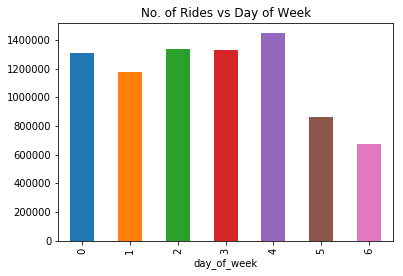

In [23]:
df.groupby('day_of_week')['num_rides'].sum().plot(kind='bar',color=color, title= 'No. of Rides vs Day of Week')

<b>We can see that number of rides booked on Weekends e.g. Saturday & Sunday, 5 & 6, are significantly less than the rides booked during weekdays.</b>

It's quite intutive as work places remains close, people commute less.

__Intresting observation: Most number of rides were booked on Friday__

Let's check the relation between number of rides book and the time of the day

In [24]:
df_hour = df_original.copy()
df_hour['num_rides'] = 1
df_hour['day_of_week']= df_hour['date'].apply(lambda x:x.weekday())

In [25]:
df_weekends = df_hour.loc[(df_hour['day_of_week'] == 5) | (df_hour['day_of_week'] == 6)]
df_weekdays = df_hour.loc[(df_hour['day_of_week'] != 5) & (df_hour['day_of_week'] != 6)]

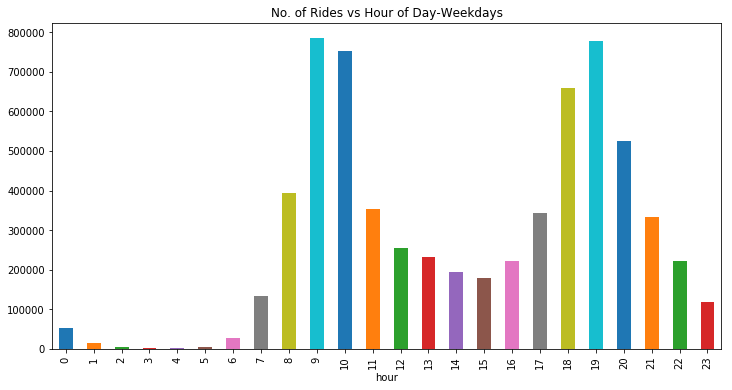

In [26]:
df_weekdays.groupby('hour')['num_rides'].sum().plot(kind='bar',
                                                    color=color,
                                                    figsize=(12,6),
                                                    title= 'No. of Rides vs Hour of Day-Weekdays')

__As expected most of rides on weedays are booked during (9 A.M. - 10 A.M.) and (6 P.M. - 7 P.M.)__ <br>
These are the typical office timings. There is huge surge in the number of rides booked during the beginning and end of people's office times. 

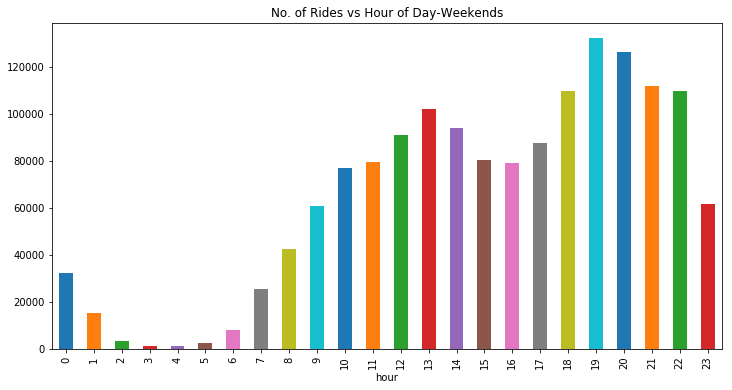

In [27]:
df_weekends.groupby('hour')['num_rides'].sum().plot(kind='bar',
                                                    color=color, 
                                                    figsize=(12,6),
                                                    title= 'No. of Rides vs Hour of Day-Weekends')

__Most of the rides during weekends are booked during 6 P.M. to 11 P.M__<br>
It's reasonable to assume their during weekends people commute during evening for hanging out or going to places.

In [28]:
import gc

In [29]:
del df_hour, df_weekdays, df_weekends
gc.collect()

69

### Now is the right time to analyze the time series

In [30]:
df.head()

,date,num_rides,day_of_week
0,2018-04-07,9169,5
1,2018-04-08,5556,6
2,2018-04-09,11360,0
3,2018-04-10,10943,1
4,2018-04-11,11892,2


In [31]:
df = df.drop(labels='day_of_week', axis=1)

In [32]:
df.set_index('date', inplace=True)

In [33]:
df.head()

,num_rides
date,
2018-04-07,9169
2018-04-08,5556
2018-04-09,11360
2018-04-10,10943
2018-04-11,11892


Let's divide the dataset into train and test set, since we onlyl have 366 data points we will be creating a validatio set

In [34]:
df_test = df.tail(30)

In [35]:
df.drop(df.tail(30).index,inplace=True) # drop last n rows

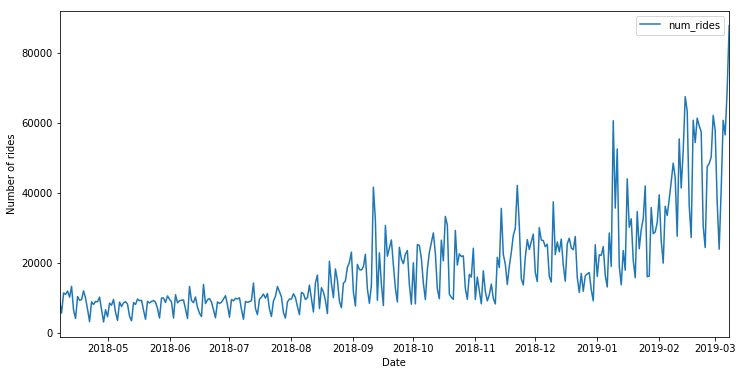

In [36]:
ax = df.plot(figsize=(12,6))
ax.set_xlabel('Date')
ax.set_ylabel('Number of rides')
plt.show()

__Point to note: From month of September 2018, there a significant increase in the number of ride bookings__

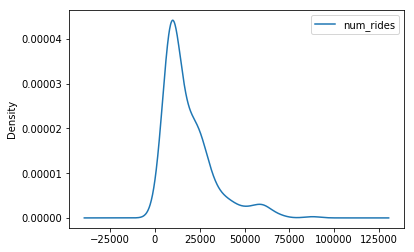

In [37]:
df.plot(kind='kde')

Upon analyzing the distribution we observe a near-normal distribution over booked rides.

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

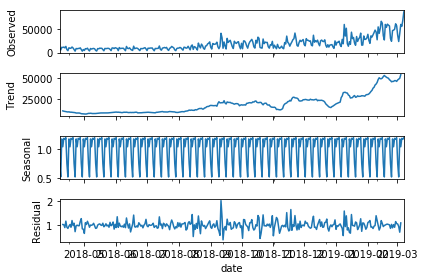

In [39]:
result = seasonal_decompose(df, model='multiplicative', freq=7)
result.plot()
plt.show()

We can see that there is a __Upward moving trend in the number of rides booked also there is a very high seasonality present in our time series.__

For a univariate time series where there is trend is seasonality present <a href="https://facebook.github.io/prophet/docs/quick_start.html">Facebook's Prophet</a> outputs a very good result.
Let's use the same for our timeseries data.

In [40]:
from fbprophet import Prophet

In [41]:
model = Prophet(weekly_seasonality=True)

In [42]:
y_rides = df['num_rides']
df_prophet = pd.DataFrame({'date':y_rides.index, 'rides':y_rides.values})
df_prophet = df_prophet.rename(columns={'date': 'ds', 'rides': 'y'})
model.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future = model.make_future_dataframe(periods=30)
fcst = model.predict(future)

In [44]:
forecast = fcst.drop(labels=['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
                   'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
                   'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
                   'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis=1)

In [45]:
forecast = forecast.rename(columns={'ds':'date','yhat':'forecasted_rides'})
forecast.set_index('date', inplace=True)

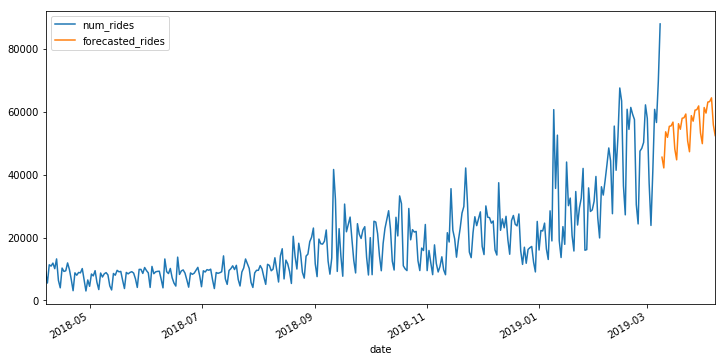

In [46]:
ax = df.plot(figsize=(12,6))
forecast.tail(30).plot(ax=ax)
plt.show()

Number of rides as forecasted by Prophet
Let's calulatate the <a href="https://en.wikipedia.org/wiki/Mean_absolute_percentage_error">M.A.P.E.</a>(Mean Absolute percentage Error) value between our forecasted rides and the actual test set

In [47]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
mean_absolute_percentage_error(df_test['num_rides'].values,forecast.tail(30)['forecasted_rides'].values)

20.273447729056173

#### Prophet did a fair forecasting, but let's try to reduce the M.A.P.E by using a different forecating model

In [49]:
del df_prophet, model, future,fcst
gc.collect()

2537

In [50]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
#Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    #plotting the rolling statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean &amp; Standard Deviation')
    plt.show(block=False)

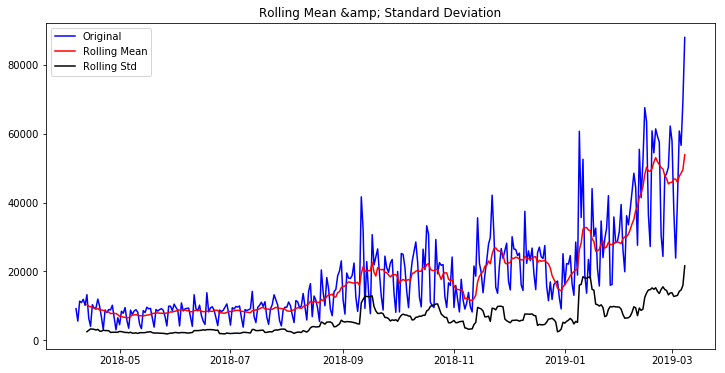

In [51]:
fig = plt.figure(figsize=(12,6))
test_stationarity(df)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.
To get a stationary series, we need to eliminate the trend and seasonality from the series.

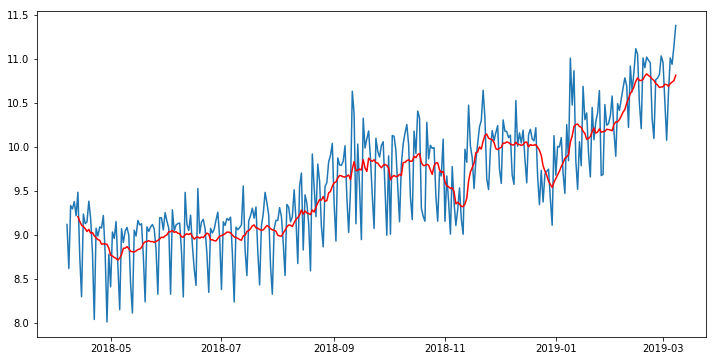

In [52]:
df_log = np.log(df)
moving_avg = df_log.rolling(7).mean()
fig = plt.figure(figsize=(12,6))
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.show()

Log transform will reduce the effect of outliers and will make the time series bit more stationary

We take the difference of the series and the mean at every point in the series. This way, we eliminate trend out of a series and obtain a more stationary series

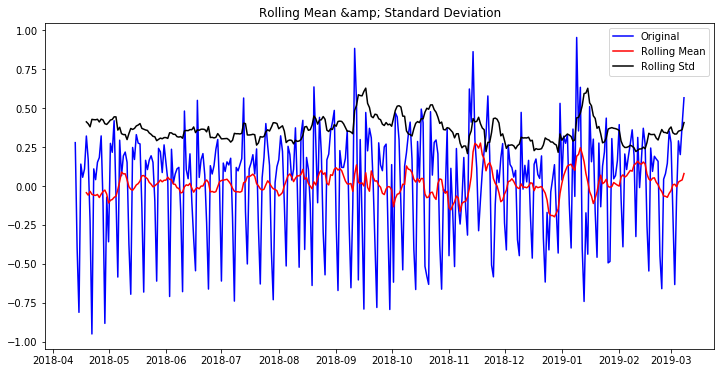

In [53]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)
fig = plt.figure(figsize=(12,6))
test_stationarity(df_log_moving_avg_diff)

Above plot also suggests a less fluctuating mean and standard deviation.

Let's now remove the temporal dependence e.g. seasonality using __Differencing__.
Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

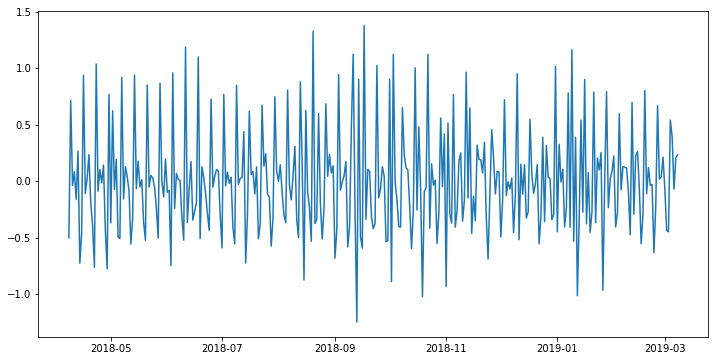

In [54]:
df_log_diff = df_log-df_log.shift()
fig = plt.figure(figsize=(12,6))
plt.plot(df_log_diff)

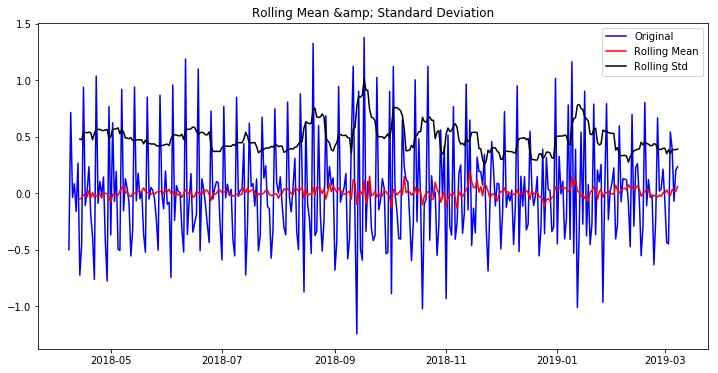

In [55]:
fig = plt.figure(figsize=(12,6))
test_stationarity(df_log_diff)

Timeseries certainly looks more stationary now

Let's decompose our logarthmic time series

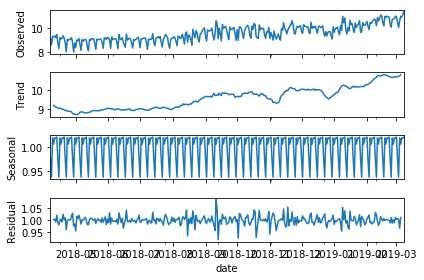

In [56]:
result = seasonal_decompose(df_log, model='multiplicative',freq=7)
result.plot()
plt.show()

In [57]:
trend = result.trend
seasonality = result.seasonal
residual = result.resid

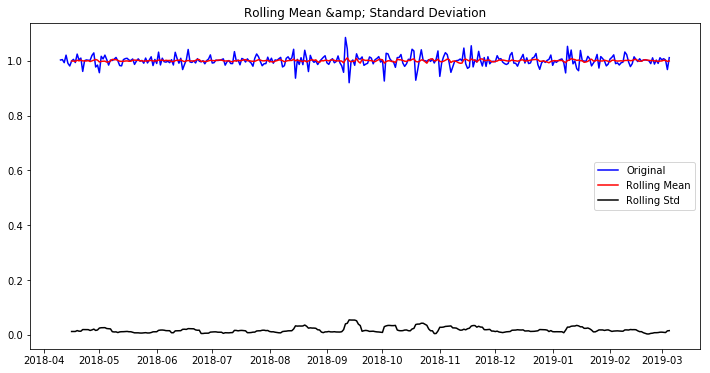

In [58]:
fig = plt.figure(figsize=(12,6))
test_stationarity(residual)

After the decomposition, if we look at the residual then we have clearly a flat line for both mean and standard deviation.
__We have got our stationary series and now let's build a model__

#### We will build an <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average"> ARIMA</a> model.

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

* p is the number of autoregressive terms,
* d is the number of nonseasonal differences needed for stationarity, and
* q is the number of lagged forecast errors in the prediction equation.

Values of p and q come through <a href="https://en.wikipedia.org/wiki/Autocorrelation">ACF and 
<a href = "https://en.wikipedia.org/wiki/Partial_autocorrelation_function">PACF</a> plots. 

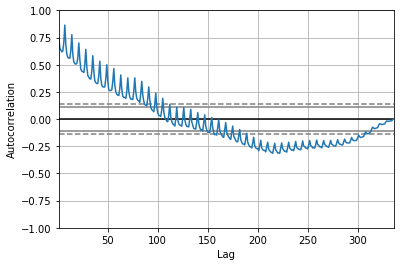

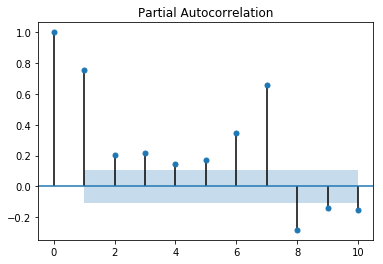

In [59]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
autocorrelation_plot(df_log)
plot_pacf(df_log, lags=10)
plt.show()

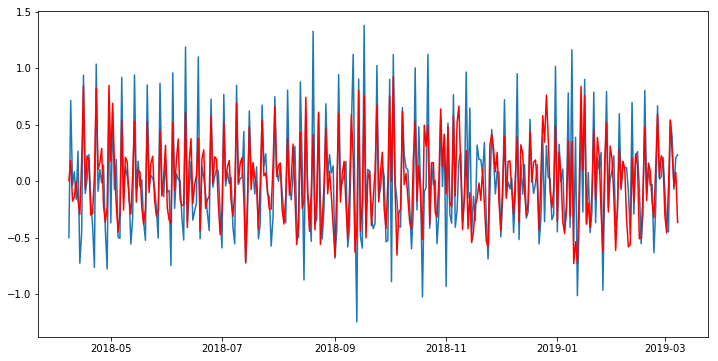

In [60]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = ARIMA(df_log, order=(4,1,4) ,freq="D")
result_AR = model.fit(disp=-1)
fig = plt.figure(figsize=(12,6))
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.show()

### What more could have been done?

* A built new model dataset which was bucktized on the __hour of day__ and forecasting could be genereted on hourly basis thus can help us from dealing with a sudden surge in the demand.
* Experimented different time-series models and Conv-1D Approach.